# CVE.ICU - Predictions
---

This information from this website is from a [jupyter notebook](https://jupyter.org/) that automatically pulls all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and perform some fundamental data analysis and graphing.  If you have any questions or suggestions, please join the [discussion here](https://github.com/jgamblin/cve.icu/discussions) and check out the [source code](https://github.com/jgamblin/cve.icu/).  Questions? Reach out to [@jgamblin](https://www.twitter.com/jgamblin).

**Yearly Data**
-  [All](https://cve.icu/)
-  [2022](2022.html)
-  [2021](2021.html)
-  [2020](2020.html)
-  [2019](2019.html)

**Other Data**
-  [CVE Growth Predictions](prophet.html)
-  [CVE Calendar All Years](calendar.html)
-  [CNA Map](cnamap.html)

In [1]:
import datetime
import glob
import json
import logging
import sys
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import os
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)


# Turn off pystan warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

# Turn off fbprophet stdout logger
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


In [2]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = 'Missing_Data_JG'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)

nvd['Published'] = pd.to_datetime(nvd['Published'])
years = ((nvd['Published'] > '2017-01-01') & (nvd['Published']  < '2022-12-31'))
nvd = nvd.loc[years]
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())

## Prophet Predictions

This notebookls performs some basic time series forecasting using [Prophet](https://facebook.github.io/prophet/) from Facebook.  

In [3]:
%%capture
orig_out = sys.stdout
sys.stdout = open(os.devnull, 'w')
cve_day = pd.DataFrame(nvd.Published.value_counts().reset_index().values, columns=["ds", "y"]);
cve_day = cve_day.sort_index(axis = 0, ascending=True);
cve_day = cve_day[cve_day['y'] <= 400]; 
m = Prophet();
m.fit(cve_day);
future = m.make_future_dataframe(periods=3650);
forecast = m.predict(future);
by_year = forecast.copy();
result = by_year.groupby(by_year.ds.dt.to_period("Y"))['yhat'].sum().round();
sys.stdout = orig_out

Initial log joint probability = -33.0992
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       2800.52    0.00020787       64.6037   2.215e-06       0.001      110  LS failed, Hessian reset 
      99       2800.53   7.93959e-07       71.9153      0.5287      0.5287      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       2800.56   2.99136e-05       99.0783   3.042e-07       0.001      349  LS failed, Hessian reset 
     199       2800.56    2.8141e-06       104.978      0.2297      0.2297      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2800.58   1.00083e-06       79.5417       1.512      0.1512      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       2800.58   2.52897e-07       86.5228      0.5998      0.5998      486   
Optimization terminat

### Prediction Per Year

In [4]:
for year, records in result.items():
    print(f"{year} - {records} CVEs")

2017 - 14717.0 CVEs
2018 - 16001.0 CVEs
2019 - 17120.0 CVEs
2020 - 18251.0 CVEs
2021 - 19949.0 CVEs
2022 - 21732.0 CVEs
2023 - 23189.0 CVEs
2024 - 24736.0 CVEs
2025 - 26106.0 CVEs
2026 - 27519.0 CVEs
2027 - 28930.0 CVEs
2028 - 30351.0 CVEs
2029 - 31780.0 CVEs
2030 - 33212.0 CVEs
2031 - 34649.0 CVEs
2032 - 911.0 CVEs


### Plot the Forecast

This shows the plot for all previous data and the next 10 years. 

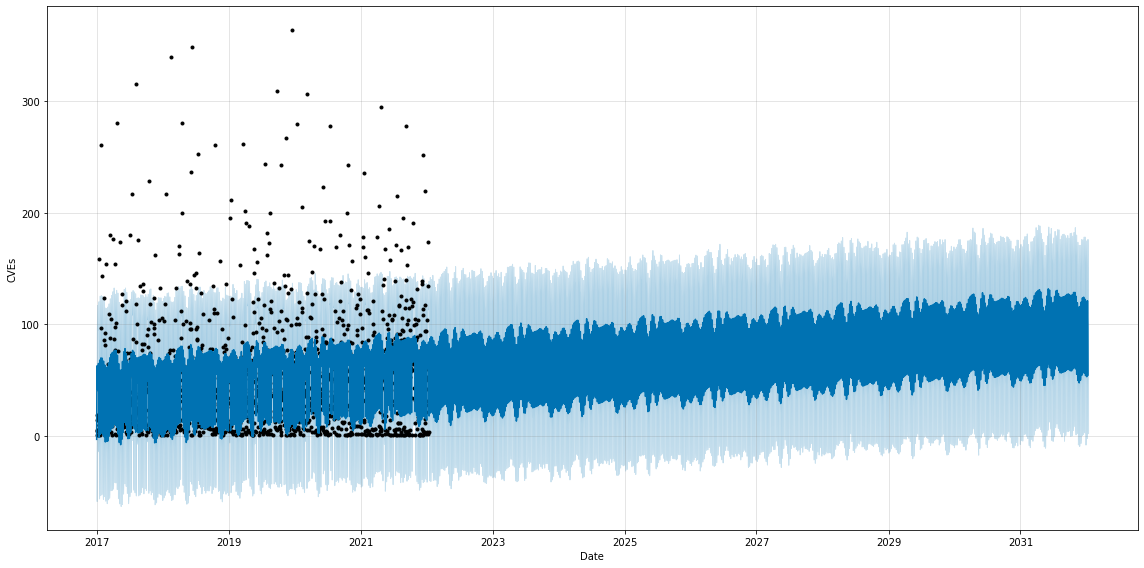

In [5]:

fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8) )

### Plot the Forecast With Change Points

This shows the plot for all previous data and the next 10 years with changepoints marked where the data had abrupt changes in its trajectories.

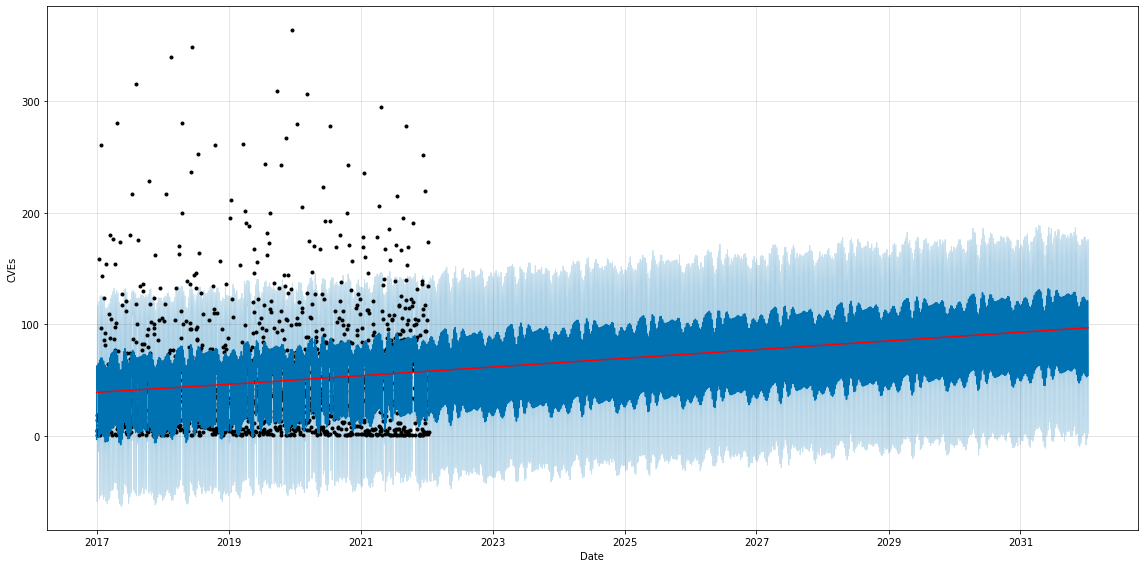

In [6]:
fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Most CVE Per Day Predictions For The Next Year

In [7]:
date_now = datetime.now()
one_year = date_now + pd.DateOffset(years=1)
five_year = date_now + pd.DateOffset(years=5)
ten_year = date_now + pd.DateOffset(years=10)


cve_prophet_thisyear = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < one_year)]
cve_prophet_thisyear =  cve_prophet_thisyear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_thisyear

,ds,yhat,yhat_lower,yhat_upper
1853,2022-06-08,97.0,45.0,152.0
1895,2022-07-20,96.0,40.0,151.0
1797,2022-04-13,96.0,42.0,150.0
1790,2022-04-06,95.0,38.0,148.0
1846,2022-06-01,95.0,44.0,147.0
1804,2022-04-20,95.0,42.0,152.0
1783,2022-03-30,94.0,38.0,147.0
1993,2022-10-26,94.0,42.0,150.0
1902,2022-07-27,94.0,38.0,145.0
1888,2022-07-13,93.0,43.0,149.0


### Most CVE Per Day Predictions For The Next 5 Years

In [8]:
cve_prophet_next5 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < five_year)]
cve_prophet_next5 = cve_prophet_next5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next5

,ds,yhat,yhat_lower,yhat_upper
3260,2026-04-15,112.0,60.0,165.0
3316,2026-06-10,112.0,55.0,172.0
3309,2026-06-03,112.0,59.0,167.0
3358,2026-07-22,111.0,55.0,168.0
3253,2026-04-08,111.0,57.0,167.0
3246,2026-04-01,110.0,59.0,166.0
3351,2026-07-15,110.0,54.0,163.0
3267,2026-04-22,110.0,58.0,165.0
3365,2026-07-29,109.0,55.0,161.0
3456,2026-10-28,109.0,53.0,164.0


### Most CVE Per Day Predictions For The Next 10 Years

In [9]:
cve_prophet_next10 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < ten_year)]
cve_prophet_next10 = cve_prophet_next10[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next10

,ds,yhat,yhat_lower,yhat_upper
5136,2031-06-04,132.0,78.0,188.0
5087,2031-04-16,131.0,76.0,189.0
5143,2031-06-11,131.0,73.0,182.0
5080,2031-04-09,130.0,75.0,189.0
5185,2031-07-23,130.0,74.0,185.0
5178,2031-07-16,130.0,73.0,180.0
5283,2031-10-29,129.0,74.0,187.0
5094,2031-04-23,129.0,72.0,182.0
5073,2031-04-02,129.0,75.0,185.0
5276,2031-10-22,129.0,75.0,183.0
